In [284]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_processing.pipelines.ClassifierPipe import ClassifierPipe

import tensorflow as tf

In [286]:
data_path = "/Users/mds8301/iterm_data_storage/raw_data_raw_data.parquet.gzip"
processor = ClassifierPipe(data_path)
processor.read_raw_data().calculate_max_min_signal()

In [119]:
da_query = "event == 'cue' & sensor=='DA'"
da_data = proc.query(da_query)
da_data = da_data.assign(max_min_ration = da_data.signal_max / da_data.signal_min,
                         signal_range = da_data.signal_max - da_data.signal_min)
da_data

,mouse_id,day,event,sensor,sex,trial_count,trial,signal_max,signal_min,num_avoids,max_trial,ratio_avoid,max_min_ration,signal_range
3,0,1,cue,DA,F,14.0,14.0,2.562477,-2.220179,5.0,28.0,0.178571,-1.154176,4.782656
11,0,2,cue,DA,F,43.0,14.0,2.644650,-2.218564,5.0,28.0,0.178571,-1.192055,4.863214
19,0,3,cue,DA,F,72.0,14.0,2.493350,-2.153072,15.0,28.0,0.535714,-1.158043,4.646422
27,0,4,cue,DA,F,101.0,14.0,2.772145,-2.124254,16.0,28.0,0.571429,-1.304997,4.896399
35,0,5,cue,DA,F,129.0,13.0,2.813738,-2.289640,13.0,26.0,0.500000,-1.228900,5.103378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,13,3,cue,DA,M,72.0,14.0,3.269249,-1.857879,12.0,28.0,0.428571,-1.759667,5.127129
719,13,4,cue,DA,M,100.0,13.0,2.821698,-1.928597,24.0,26.0,0.923077,-1.463083,4.750296
727,13,5,cue,DA,M,128.0,14.0,2.858959,-2.079169,26.0,28.0,0.928571,-1.375049,4.938128
735,13,6,cue,DA,M,156.5,13.5,3.585222,-2.072207,23.0,27.0,0.851852,-1.730147,5.657430


In [297]:
processor_pipe = (ClassifierPipe(data_path)
             .read_raw_data()
             .calculate_max_min_signal()
             .calculate_percent_avoid()
             .drop_columns(["event", "action", "trial", "trial_count", "num_avoids", "max_trial"])
             .split_data(test_size=0.3,
                test_dev_size=0.5, 
                split_group = "mouse_id", 
                stratify_group = "sex", 
                target='ratio_avoid',
                save_subject_ids=False)
                # path_to_save =os.path.dirname(raw_path)
            .transorm_data()
)
processor_pipe.X_train

array([[ 0.03299123,  0.04529636, -0.61236023, ...,  1.        ,
         1.        ,  0.        ],
       [-0.75839918,  0.04529636, -0.8629278 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.28599278, -0.94176598,  0.84672135, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.03299123,  1.03235869,  0.92621238, ...,  1.        ,
         1.        ,  0.        ],
       [ 1.08817843, -1.43529715, -1.32498926, ...,  0.        ,
         0.        ,  1.        ],
       [-1.28599278, -0.94176598,  0.49752656, ...,  1.        ,
         1.        ,  0.        ]])

In [336]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    # tf.keras.layers.Dense(256, activation='relu'),
    # tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='mse')
model.fit(processor_pipe.X_train, processor_pipe.y_train, validation_data=(processor_pipe.X_dev, processor_pipe.y_dev),epochs=400)


Epoch 1/400
124/124 [==============================] - 2s 10ms/step - loss: 0.5902 - val_loss: 0.5181
Epoch 2/400
124/124 [==============================] - 1s 8ms/step - loss: 0.5605 - val_loss: 0.4795
Epoch 3/400
124/124 [==============================] - 1s 8ms/step - loss: 0.5291 - val_loss: 0.4451
Epoch 4/400
124/124 [==============================] - 1s 8ms/step - loss: 0.4980 - val_loss: 0.4160
Epoch 5/400
124/124 [==============================] - 1s 8ms/step - loss: 0.4755 - val_loss: 0.3900
Epoch 6/400
124/124 [==============================] - 1s 8ms/step - loss: 0.4520 - val_loss: 0.3673
Epoch 7/400
124/124 [==============================] - 1s 8ms/step - loss: 0.4303 - val_loss: 0.3462
Epoch 8/400
124/124 [==============================] - 1s 8ms/step - loss: 0.4181 - val_loss: 0.3286
Epoch 9/400
124/124 [==============================] - 1s 8ms/step - loss: 0.4017 - val_loss: 0.3132
Epoch 10/400
124/124 [==============================] - 1s 8ms/step - loss: 0.3862 - val_l

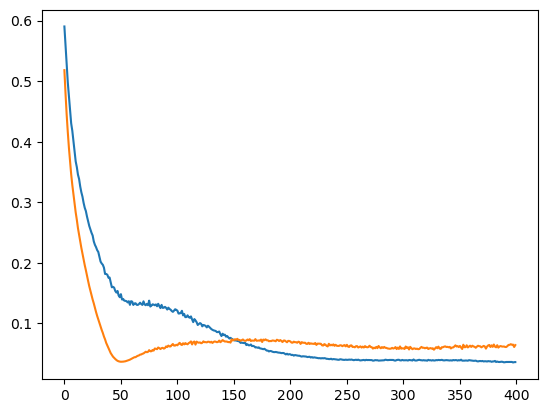

In [337]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])

In [338]:
predicted_signal = model.predict(processor_pipe.X_test)

82/82 [==============================] - 0s 2ms/step


<Axes: xlabel='day', ylabel='true_avoid_ratio'>

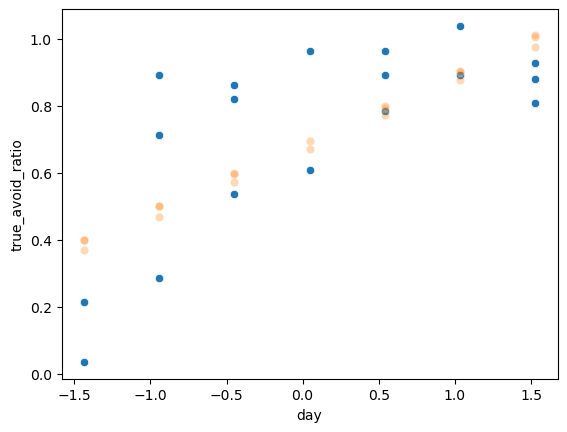

In [339]:
num_cols = processor_pipe.processor.named_transformers_["num"].get_feature_names_out().tolist()
cat_cols = processor_pipe.processor.named_transformers_["cat"].get_feature_names_out().tolist()
cols = num_cols + cat_cols

testing_df = (pd.DataFrame(processor_pipe.X_test, columns=cols)
              .assign(predicted_avoid_ratio = predicted_signal, 
                      true_avoid_ratio = processor_pipe.y_test.values.reshape(-1,1)
                      )
)
dopamine = testing_df.query("sensor_DA ==1").drop(columns = ["sex_M"]).drop_duplicates(subset = ["mouse_id", "day"])
sns.scatterplot(data=dopamine, x="day", y="true_avoid_ratio")
sns.scatterplot(data=dopamine, x="day", y="predicted_avoid_ratio", alpha=0.3)

In [331]:
dopamine.sort_values("day")

,mouse_id,day,signal_max,signal_min,sensor_D1,sensor_D2,sensor_DA,sex_F,predicted_avoid_ratio,true_avoid_ratio
1,-0.230806,-1.435297,0.488197,-0.097494,0.0,0.0,1.0,0.0,0.618461,0.035714
1760,1.615772,-1.435297,0.412352,0.136377,0.0,0.0,1.0,1.0,0.680368,0.214286
967,0.824382,-1.435297,-1.685753,-0.770749,0.0,0.0,1.0,0.0,0.760579,0.214286
173,-0.230806,-0.941766,2.953018,0.371888,0.0,0.0,1.0,0.0,0.547450,0.285714
1938,1.615772,-0.941766,-0.435488,0.002563,0.0,0.0,1.0,1.0,0.752748,0.892857
1138,0.824382,-0.941766,-0.662006,-0.594771,0.0,0.0,1.0,0.0,0.752387,0.714286
2057,1.615772,-0.448235,0.575019,-0.360048,0.0,0.0,1.0,1.0,0.752758,0.821429
1278,0.824382,-0.448235,2.423272,0.947322,0.0,0.0,1.0,0.0,0.640863,0.862069
333,-0.230806,-0.448235,0.277062,0.182072,0.0,0.0,1.0,0.0,0.695023,0.535714
481,-0.230806,0.045296,0.446160,0.744978,0.0,0.0,1.0,0.0,0.716107,0.607143


In [353]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth = 3, learning_rate = 0.1)
xgb_model.fit(processor_pipe.X_train, processor_pipe.y_train)
xg_pred = xgb_model.predict(processor_pipe.X_test)


<Axes: xlabel='day', ylabel='true_avoid_ratio'>

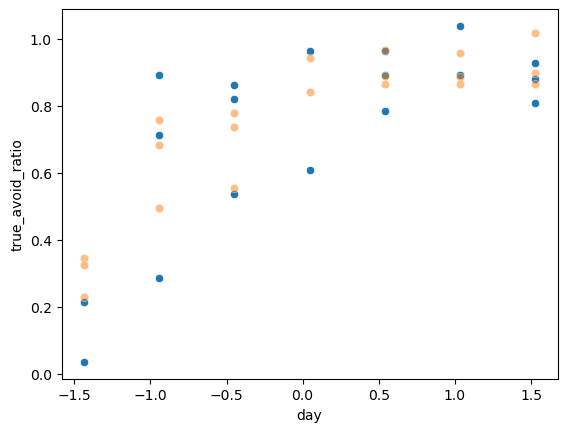

In [354]:
testing_df = testing_df.assign(xg_pred_avoid_ratio = xg_pred)
dopamine = testing_df.query("sensor_DA ==1").drop(columns = ["sex_M"]).drop_duplicates(subset = ["mouse_id", "day"])
sns.scatterplot(data=dopamine, x="day", y="true_avoid_ratio")
# sns.scatterplot(data=dopamine, x="day", y="predicted_avoid_ratio", alpha=0.3)
sns.scatterplot(data=dopamine, x="day", y="xg_pred_avoid_ratio", alpha=0.5)

In [344]:
testing_df

,mouse_id,day,signal_max,signal_min,sensor_D1,sensor_D2,sensor_DA,sex_F,sex_M,predicted_avoid_ratio,true_avoid_ratio,xg_pred_avoid_ratio
0,-0.230806,-1.435297,-0.315324,0.160673,1.0,0.0,0.0,0.0,1.0,0.344309,0.035714,0.464034
1,-0.230806,-1.435297,0.488197,-0.097494,0.0,0.0,1.0,0.0,1.0,0.400825,0.035714,0.464067
2,-0.230806,-1.435297,0.143361,-0.221332,1.0,0.0,0.0,0.0,1.0,0.347528,0.035714,0.464034
3,-0.230806,-1.435297,3.621173,-0.252239,0.0,0.0,1.0,0.0,1.0,0.407602,0.035714,0.464034
4,-0.230806,-1.435297,0.966162,1.119450,1.0,0.0,0.0,0.0,1.0,0.340732,0.035714,0.464155
...,...,...,...,...,...,...,...,...,...,...,...,...
2618,1.615772,1.525890,0.556783,0.054046,0.0,0.0,1.0,1.0,0.0,0.970564,0.928571,1.007488
2619,1.615772,1.525890,-1.296870,-0.477033,0.0,1.0,0.0,1.0,0.0,1.054842,0.928571,1.005755
2620,1.615772,1.525890,-0.532616,-2.636332,0.0,0.0,1.0,1.0,0.0,0.985248,0.928571,1.007009
2621,1.615772,1.525890,-1.096782,-0.474686,0.0,1.0,0.0,1.0,0.0,1.055199,0.928571,1.006490
